In [16]:
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
import imblearn 
from imblearn.under_sampling import RandomUnderSampler
print(imblearn.__version__)

0.10.1


In [3]:
def datasetPrep(dataset):
    #pulls data from csv
    df = read_csv(dataset, header=None)
    
    #add labels to all the columnns 
    df.columns = ['ID', 
                'Label',
                'Statement',
                'Subject',
                'Speaker',
                'Occupation',
                'Location',
                'Party',
                'Barely True Counts',
                'False Counts',
                'Half True Counts',
                'Mostly True Counts',
                'Pants on Fire Counts',
                'Context']
    
    #drops columns that are not helpful.
    df = df.drop(['Location',
                # 'Occupation',
                'Barely True Counts',
                'False Counts',
                'Half True Counts',
                'Mostly True Counts',
                'Pants on Fire Counts'], axis=1)
    
    #drops rows that have been labeled "half-true"
    df = df.drop(df[df['Label'] == 'half-true'].index)

    #drops rows with information missing in columns
    df = df.dropna()
    
    #drops rows with duplicates 
    df = df.drop_duplicates()  
    
    # combines all the different text information into one string.
    df['Combined Data'] = df['Statement'] + '\n' + df['Subject'] + '\n' + df['Speaker'] + '\n' + df['Party'] + '\n' + df['Occupation'] + '\n' + df['Context']
    
    X = df['Combined Data']
    
    Y = df['Label']
    
    #X = X.astype(str)
    Y = TwoClassConversion(Y)
    #print(X[0])

    return X, Y 
    
# datasetPrep("Dataset/Train csv_version.csv")

In [4]:
def TwoClassConversion(outputs):
    outputs = outputs.replace(["barely-true","pants-fire"], "FALSE")
    outputs = outputs.replace(["mostly-true"], "TRUE")
    return outputs

In [5]:
def testModel(model, data, output):
    predicted = model.predict(data)
    print(classification_report(output, predicted))
    labels = ["False", "True"]
    conMat = confusion_matrix(output, predicted)
    conHeatMap = sns.heatmap(conMat.T, square = True, annot = True, fmt = 'd', xticklabels = labels, yticklabels = labels)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()

In [6]:
def featureVectorizing(x,xTest,xValid):
   
    # setup count vectorizer and tfidf transformer
    
    count_vect = CountVectorizer()
    tfTransformer = TfidfTransformer()
    
    # feature extraction of training set
    xTrainCounts = count_vect.fit_transform(x)
    xTrainTF = tfTransformer.fit_transform(xTrainCounts)
    
    # feature extraction of testing set
    xTestCounts = count_vect.transform(xTest)
    xTestTF = tfTransformer.transform(xTestCounts)
    
    # feature extraction of validation set
    xValidCounts = count_vect.transform(xValid)
    xValidTF = tfTransformer.transform(xValidCounts)
    
    # converting feature extracted data strucutures into arrays
    xTrainTF = xTrainTF.toarray()
    xTestTF = xTestTF.toarray()
    xValidTF = xValidTF.toarray()
    
    return xTrainTF, xTestTF, xValidTF
    

In [7]:
def multiNBModel(x,y):
    nbClf = MultinomialNB().fit(x,y)
    return nbClf

In [8]:
def svmModel(x,y):
    svmClf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None).fit(x,y)
    return svmClf

In [9]:
def xgBoostModel(x,y):
    xgBoostClf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(x, y)
    return xgBoostClf

In [10]:
def svmSVCModel(x,y):
    model = SVC().fit(x, y)
    return model

In [17]:
def reBalance(x,y):
    oversample = RandomUnderSampler(random_state=0)
    xR, yR = oversample.fit_resample(x, y)
    return xR, yR

Multinomial Naive Bayes
              precision    recall  f1-score   support

       FALSE       0.63      0.58      0.60       353
        TRUE       0.61      0.65      0.63       353

    accuracy                           0.62       706
   macro avg       0.62      0.62      0.62       706
weighted avg       0.62      0.62      0.62       706



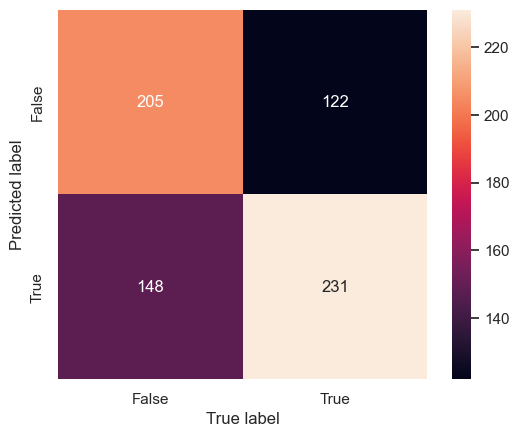


Linear SVM
              precision    recall  f1-score   support

       FALSE       0.71      0.45      0.55       353
        TRUE       0.60      0.82      0.69       353

    accuracy                           0.63       706
   macro avg       0.65      0.63      0.62       706
weighted avg       0.65      0.63      0.62       706



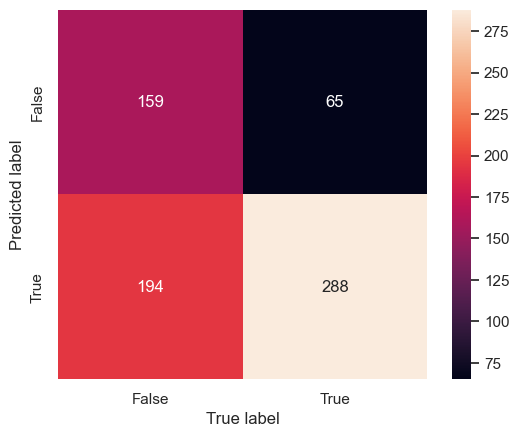

svcSVM model without pipeline
              precision    recall  f1-score   support

       FALSE       0.64      0.62      0.63       353
        TRUE       0.63      0.65      0.64       353

    accuracy                           0.63       706
   macro avg       0.63      0.63      0.63       706
weighted avg       0.63      0.63      0.63       706



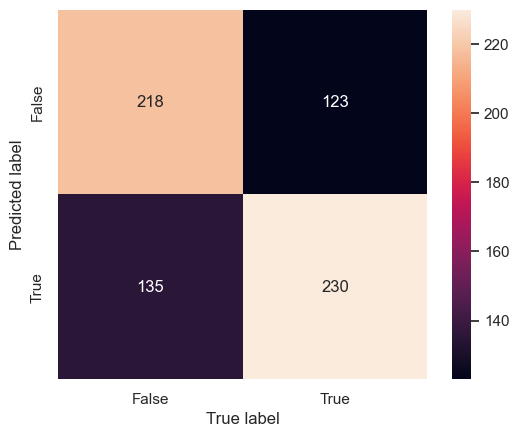

xgboost
              precision    recall  f1-score   support

       FALSE       0.62      0.59      0.61       353
        TRUE       0.61      0.63      0.62       353

    accuracy                           0.61       706
   macro avg       0.61      0.61      0.61       706
weighted avg       0.61      0.61      0.61       706



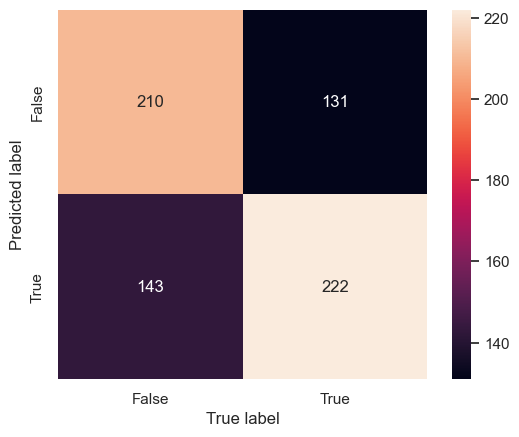

In [18]:
def withoutPipeline():
    trainDataset = "Dataset/Train csv_version.csv"
    testDataset = "Dataset/Test csv_version.csv"
    validDataset = "Dataset/Valid csv_version.csv"

    x,y = datasetPrep(trainDataset)
    xT, yT = datasetPrep(testDataset)
    xV, yV = datasetPrep(validDataset)
    
    xTrainC, xTestC, xValidC = featureVectorizing(x, xT, xV)
    
    xR, y = reBalance(xTrainC, y)
    xTR, yT = reBalance(xTestC, yT)
    
    print("Multinomial Naive Bayes")
    modelNB = multiNBModel(xR,y)
    testModel(modelNB, xTR, yT)
    
    print()
    print("Linear SVM")
    modelSVM = svmModel(xR, y)
    testModel(modelSVM, xTR, yT)
    
    print("svcSVM model without pipeline")
    model = svmSVCModel(xR, y)
    testModel(model, xTR, yT)
    
    print("xgboost")
    model = xgBoostModel(xR, y)
    testModel(model, xTR, yT)

withoutPipeline()

In [25]:
def getData():
    trainDataset = "Dataset/Train csv_version.csv"
    testDataset = "Dataset/Test csv_version.csv"
    validDataset = "Dataset/Valid csv_version.csv"
    
    x,y = datasetPrep(trainDataset)
    xT, yT = datasetPrep(testDataset)
    xV, yV = datasetPrep(validDataset)
    
    #x, xV, y, yV = train_test_split(x, y, test_size = 0.3, random_state=88)    
    
    return x,y,xT,yT,xV,yV
    

In [26]:
def nbPipeline():
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
])
    return pipeline

In [27]:
def svmPipeline():
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None))
])
    return pipeline

In [28]:
def svmSvcPipeline():
        pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC())
])
        return pipeline

In [29]:
def decisionTreePipeline():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier())
    ])
    return pipeline


In [30]:
def randomForestPipeline():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier())
    ])
    return pipeline

In [31]:
def xgBoostPipeline():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0))
    ])
    return pipeline
    

In [32]:
def parameterTuning(model, x, y, parameters):
    
    # print(model.get_params())   
    
    gsModel = GridSearchCV(model, parameters, cv=10, n_jobs=-1)

    gsModel.fit(x, y)
    return gsModel


In [33]:
def kfold(model, x, y):
    kf = KFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(model, x, y, cv=kf, scoring='accuracy')
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Multinomial Naive Bayes
              precision    recall  f1-score   support

       FALSE       0.62      0.74      0.68       389
        TRUE       0.64      0.50      0.56       353

    accuracy                           0.63       742
   macro avg       0.63      0.62      0.62       742
weighted avg       0.63      0.63      0.62       742



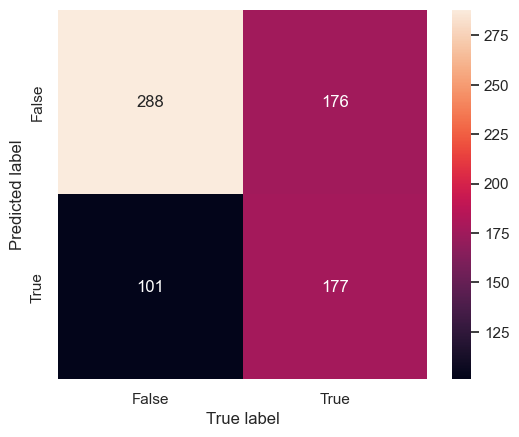


MNB with Parameter Tuning
              precision    recall  f1-score   support

       FALSE       0.59      0.65      0.62       389
        TRUE       0.57      0.51      0.54       353

    accuracy                           0.58       742
   macro avg       0.58      0.58      0.58       742
weighted avg       0.58      0.58      0.58       742



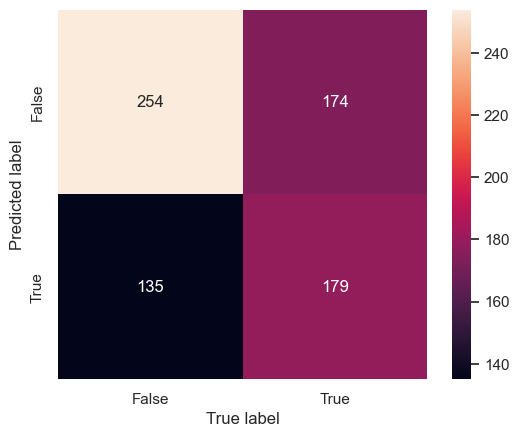


MNB with K-Fold Cross Validation
0.63 accuracy with a standard deviation of 0.02


In [34]:
def mnb(x,y,xT,yT,xV,yV):
        
    print("Multinomial Naive Bayes")
    nbModel = nbPipeline()
    nbModel = nbModel.fit(x,y)
    testModel(nbModel, xT, yT)
            
    mnbParameters = {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'clf__alpha': (1e-2, 1e-3)
    }   

    print()
    print("MNB with Parameter Tuning")
    nbTuned = parameterTuning(nbModel, xV, yV, mnbParameters)
    testModel(nbTuned, xT, yT)

    print()
    print("MNB with K-Fold Cross Validation")
    nbnewModel = nbPipeline()
    kfold(nbnewModel, x, y)
    
x,y,xT,yT,xV,yV = getData()
mnb(x,y,xT,yT,xV,yV)


Linear SVM
              precision    recall  f1-score   support

       FALSE       0.63      0.73      0.68       389
        TRUE       0.64      0.53      0.58       353

    accuracy                           0.63       742
   macro avg       0.63      0.63      0.63       742
weighted avg       0.63      0.63      0.63       742



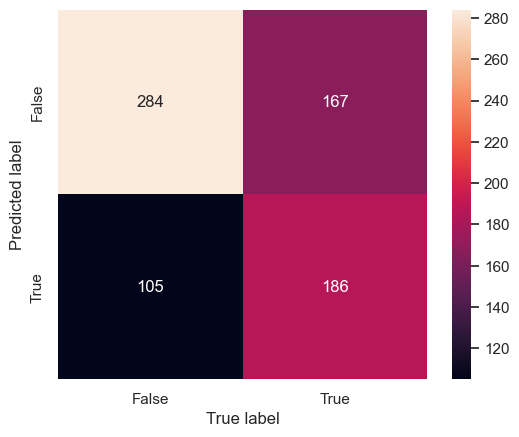


Linear SVM with Parameter Tuning
              precision    recall  f1-score   support

       FALSE       0.59      0.67      0.63       389
        TRUE       0.58      0.50      0.53       353

    accuracy                           0.59       742
   macro avg       0.58      0.58      0.58       742
weighted avg       0.59      0.59      0.58       742



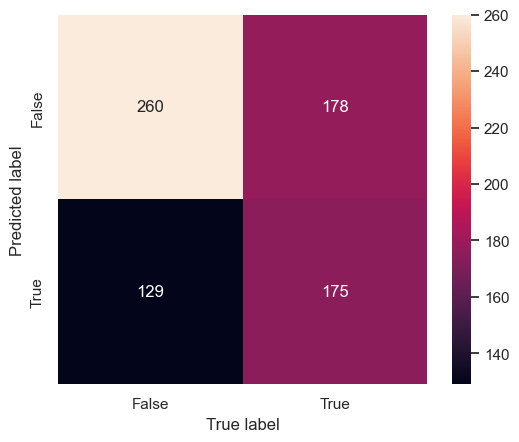


Linear SVM with K-Fold Cross Validation
0.64 accuracy with a standard deviation of 0.02


In [35]:
def svm(x,y,xT,yT,xV,yV):
    
    print()
    print("Linear SVM")
    svmModel = svmPipeline()
    svmModel = svmModel.fit(x,y)
    testModel(svmModel, xT, yT)
    
    svmParameters = {
        "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
        "vect__min_df": (1, 3, 5, 10),
        "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
        "tfidf__norm": ("l1", "l2"),
        "clf__alpha": np.logspace(-6, 6, 13),
    }
    
    print()
    print("Linear SVM with Parameter Tuning")
    svmTuned = parameterTuning(svmModel, xV, yV, svmParameters)
    testModel(svmTuned, xT, yT)
    
    print()
    print("Linear SVM with K-Fold Cross Validation")
    svmnewModel = svmPipeline()
    kfold(svmnewModel, x, y)

x,y,xT,yT,xV,yV = getData()
svm(x,y,xT,yT,xV,yV)


SVM-SVC
              precision    recall  f1-score   support

       FALSE       0.65      0.68      0.67       389
        TRUE       0.63      0.60      0.62       353

    accuracy                           0.64       742
   macro avg       0.64      0.64      0.64       742
weighted avg       0.64      0.64      0.64       742



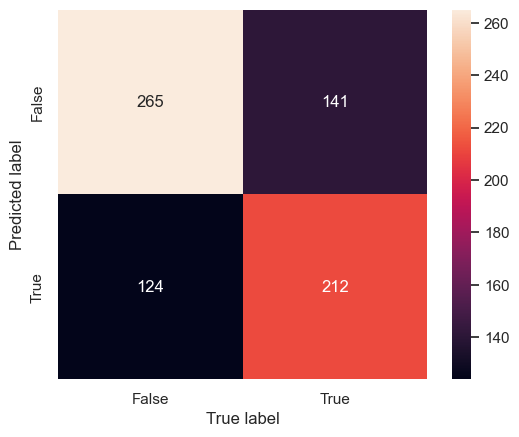


SVM-SVC with parameter Tuning
              precision    recall  f1-score   support

       FALSE       0.58      0.70      0.63       389
        TRUE       0.57      0.44      0.50       353

    accuracy                           0.58       742
   macro avg       0.57      0.57      0.57       742
weighted avg       0.57      0.58      0.57       742



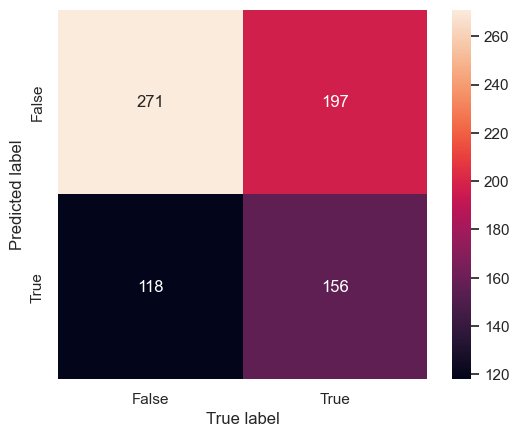

In [36]:
def svmSvc(x,y,xT,yT,xV,yV):
    
    print()
    print("SVM-SVC")
    svmSvcModel = svmSvcPipeline()
    svmSvcModel = svmSvcModel.fit(x,y)
    testModel(svmSvcModel, xT, yT)
    
    SvmSvcParameters = {
        "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
        "vect__min_df": (1, 3, 5, 10),
        "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
        "tfidf__norm": ("l1", "l2"),
        'clf__C': [0.1, 1, 10, 100],
        'clf__gamma': [0.01, 0.1, 1, 10],
        'clf__kernel': ['rbf', 'linear', 'poly']}
    
    print()
    print("SVM-SVC with parameter Tuning")
    svmSvcTuned = parameterTuning(svmSvcModel, xV, yV, SvmSvcParameters)
    testModel(svmSvcTuned, xT, yT)

x,y,xT,yT,xV,yV = getData()
svmSvc(x,y,xT,yT,xV,yV)


Decision Tree
              precision    recall  f1-score   support

       FALSE       0.59      0.56      0.57       389
        TRUE       0.54      0.57      0.55       353

    accuracy                           0.56       742
   macro avg       0.56      0.56      0.56       742
weighted avg       0.56      0.56      0.56       742



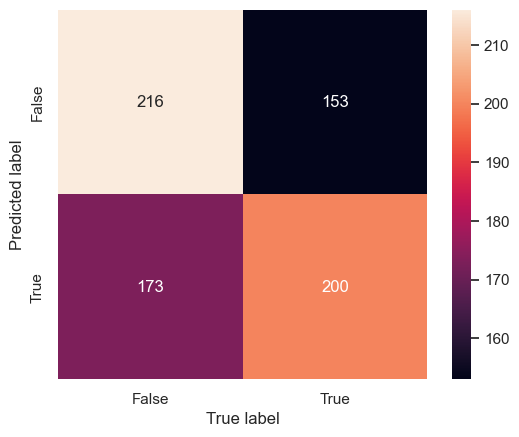

In [37]:
def decTree(x,y,xT,yT,xV,yV):
    print()
    print("Decision Tree")
    decsTreeModel = decisionTreePipeline()
    decsTreeModel = decsTreeModel.fit(x,y)
    testModel(decsTreeModel, xT, yT)

x,y,xT,yT,xV,yV = getData()
decTree(x,y,xT,yT,xV,yV)


Random Forest
              precision    recall  f1-score   support

       FALSE       0.64      0.72      0.68       389
        TRUE       0.64      0.55      0.59       353

    accuracy                           0.64       742
   macro avg       0.64      0.64      0.64       742
weighted avg       0.64      0.64      0.64       742



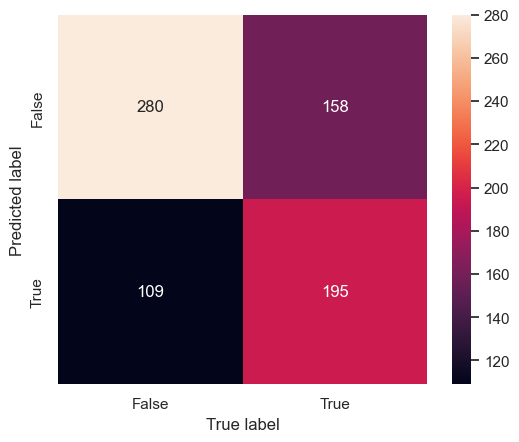

In [38]:
def randForest(x,y,xT,yT,xV,yV):
    print()
    print("Random Forest")
    randForestModel = randomForestPipeline()
    randForestModel = randForestModel.fit(x,y)
    testModel(randForestModel, xT, yT)

x,y,xT,yT,xV,yV = getData()
randForest(x,y,xT,yT,xV,yV)


XGBoost
              precision    recall  f1-score   support

       FALSE       0.63      0.65      0.64       389
        TRUE       0.60      0.57      0.59       353

    accuracy                           0.61       742
   macro avg       0.61      0.61      0.61       742
weighted avg       0.61      0.61      0.61       742



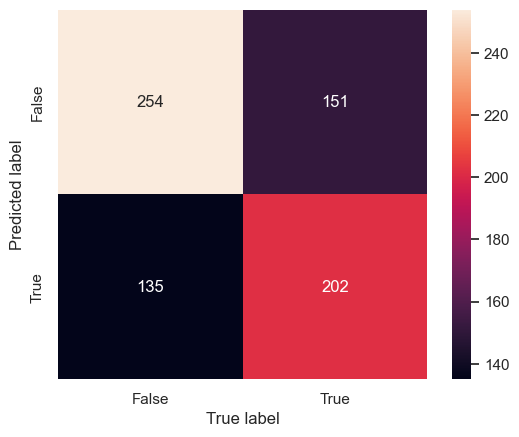

In [39]:
def xgboost(x,y,xT,yT,xV,yV):
    print()
    print("XGBoost")
    xgBoostModel = xgBoostPipeline()
    xgBoostModel = xgBoostModel.fit(x,y)
    testModel(xgBoostModel, xT, yT)

x,y,xT,yT,xV,yV = getData()
xgboost(x,y,xT,yT,xV,yV)